### Gaussian mixture 

$\pi (x) = \frac{1}{2(2\pi)^{d/2}} \left( e ^{\frac{-| x-a|^2}{2}}  + e ^{\frac{-| x+a|^2}{2}} \right), \quad x \in\mathbb R^d$

$U(x) = \frac{1}{2} \|x - a\|_2^2 - \text{log}(1 + e^{-2x^\top a})$

$\nabla U(x) = x-a +2a(1 + e^{2 x^\top a})^{-1}$

$ m = 1 - \|a \|_2^2 \quad $ (strongly convex function)

$M = 1 \quad$  (Lipschitz continuous gradient)

$a = (\frac{1}{\sqrt{2d}}, \dots, \frac{1}{\sqrt{2d}})$

##### Setup:

d = 1

n = 1000

N = 50000

N_train = 500 (100)

N_test = 200

polynomials_max_deg = 5

$f(x) = x$

$k = 1$

In [1]:
import numpy as np
import scipy 
from scipy.stats import bernoulli
from scipy.stats import multivariate_normal
from scipy.misc import comb
from matplotlib import pyplot as plt
from scipy.special import hermitenorm
from tqdm import tqdm
from numpy.polynomial.hermite_e import HermiteE
import matplotlib.mlab as mlab
%matplotlib inline
from joblib import Parallel, delayed
from scipy.optimize import minimize
from itertools import product
import sys
import warnings
from sklearn import linear_model
import math
if not sys.warnoptions:
    warnings.simplefilter("ignore")
from numpy.random import normal  
import timeit

### Parameters inicialization, ULA algorithm

In [2]:
d = 1
a = 1/np.sqrt(2)

def f_grad(x):
    return x-a+2*a/(1 + np.exp(2* (x.T * a)))

def generate_lmc(a,d,N):
    h = 0.1
    K = 10000
    vkh = np.empty((K + N,d,1))
    ksi = np.random.randn(K+N,d,1)
    vkh[0] = (np.random.normal(0,1,d)).reshape(d,1)
    for i in range(1,K+N):
        grad = f_grad(vkh[i-1])
        vkh[i] = vkh[i-1] - h*grad + np.sqrt(2*h) * ksi[i]
    return vkh[K-1:], ksi[K-1:]

### Sample generation

In [3]:
np.random.seed(123)
X, Z = generate_lmc(a,d,100000)

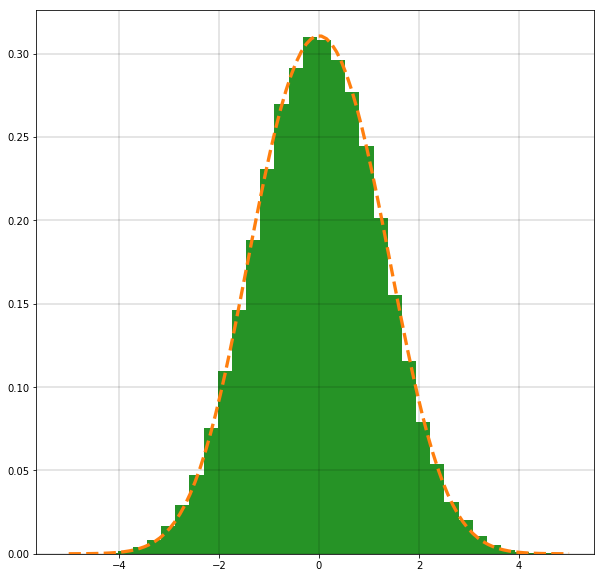

In [4]:
def f_1d(x):
    return 1/(2 * (2*np.pi)**(1/2)) * (np.exp(-0.5* (x-a)**2) + np.exp(-0.5 *(x+a)**2))

plt.figure(figsize=(10,10))
n, bins, patches = plt.hist(X.reshape(-1,1), 35, density=True, facecolor='g', alpha=0.85)
x = np.linspace(-5,5,100)
plt.plot(x, f_1d(x), linestyle='--',linewidth=3.3)
plt.grid(linestyle='-', linewidth=0.2, color='black')
plt.show()

### Ordinary weighted estimator with $$f(x) = x$$

In [5]:
def local_weighted_estimator(X):
    return X.mean()

In [6]:
print ("Weighted estimator = ",local_weighted_estimator(X))

Weighted estimator =  -0.006888872335796317


### Generation of N_train independent paths

In [7]:
def generate_lmc_from_initial(x_initial,a,d,N):
    h = 0.1
    vkh = np.empty((N,d,1))
    ksi = np.random.randn(N,d,1)
    vkh[0] = x_initial
    for i in range(1,N):
        grad = f_grad(vkh[i-1])
        vkh[i] = vkh[i-1] - h*grad + np.sqrt(2*h) * ksi[i]
    return vkh, ksi

def generate_paths(x_initial,N_train,a,d,N):
    XX = []
    ZZ = []
    for i in range(N_train):
        X, Z = generate_lmc_from_initial(x_initial[-i],a,d,N)
        XX.append(X)
        ZZ.append(Z)
    return np.array(XX),np.array(ZZ)

In [8]:
np.random.seed(123)
XX, ZZ = generate_paths(X,100,a,d,1000)

In [9]:
XX.shape

(100, 1000, 1, 1)

### Generate validation path

In [10]:
np.random.seed(42)
X_validate, Z_validate = generate_lmc_from_initial(X[-5000],a,d,1000)

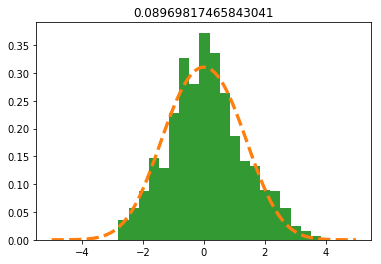

In [11]:
n, bins, patches = plt.hist(X_validate.reshape(-1,1), 20, density=True, facecolor='g', alpha=0.8)
x = np.linspace(-5,5,100)
plt.plot(x, f_1d(x), linestyle='--',linewidth=3.3)
plt.title((local_weighted_estimator(X_validate)))
plt.show()

### (normalized) Hermite polynomials

In [12]:
def H(k, x):
    h = hermitenorm(k)(x)/np.sqrt(math.factorial(k))
    return h

## Fitting linear regression for 

## $Q_{p,l}(x) = \mathbb{E} \left[f(X_p) | X_l = x\right]$

### Agorithm (one - step expectations):

## $\hat{Q}_{p,l} = argmin_{\psi \in \Psi} \sum_{s = 1}^{N_{train}} \left| \hat{Q}_{p,l+1}(X_{l+1}^{(s)}) - \psi (X_l^{(s)}) \right|^2$ 

### where $\quad N +1  \leq l <p \leq N+n$

## $\hat{Q}_{p,p} (x) = f(x) \quad \forall p$ 


### $\Psi = \left\{ 1,x,x^2, x^3, x^4, x^5 \right\}$

In [19]:
def pol_ar_1d(x):
    return np.array([1,x,x**2,x**3,x**4,x**5])

def generate_X(XX,l):
    N_train = XX.shape[0]
    X = np.empty((N_train,6))
    for i in range(6):
        pol = lambda t: t ** i
        vfunc = np.vectorize(pol)
        pol_X = vfunc(XX[:,l]).reshape(N_train)
        X[:,i] = pol_X
    return X   

def generate_y(XX,Betas,p,l):
    if p == l:
        y = XX[:,l]
        return y
    N_train = XX.shape[0]
    y = np.zeros(N_train)
    for s in range(N_train):
        y[s] = q_pl_predict(XX[s,l+1],p,l+1,Betas)
    return y

def q_pl_fit(XX):
    N_train = XX.shape[0]
    N = XX.shape[1]
    Betas = np.zeros((N,N,6))
    for p in tqdm(range(N)):
        Betas[p,p] = [0,1,0,0,0,0]
        for l in range (p-1,-1,-1):
            X = generate_X(XX,l)
            y = generate_y(XX,Betas,p,l)
            beta = np.linalg.inv(X.T @ X) @ X.T @ y
            Betas[p,l] = beta
    return Betas

def q_pl_predict(x,p,l,Betas):
    x_pol = pol_ar_1d(x)
    beta = Betas[p,l]
    return (x_pol @ beta)

In [149]:
# Betas = q_pl_fit(XX)

In [143]:
# np.save('GM_Betas.npy',Betas)
# np.save('GM_XX.npy',XX)
# np.save('GM_ZZ.npy',ZZ)

In [13]:
Betas = np.load('GM_Betas.npy')
XX = np.load('GM_XX.npy')
ZZ = np.load('GM_ZZ.npy')

### Reduced variant

## Fitting linear regression for 

## $Q_{p,l}(x) = \mathbb{E} \left[f(X_p) | X_l = x\right] = G_{p-l}(x) = \mathbb{E} \left[ f(\varPhi ^{p-l} (x, \xi))\right]$


### $\forall l: \quad G_r(x) = \mathbb{E} \left[f(X_{l+r}) | X_l = x \right] $

### Algorithm (trajectory + all variations):

## $\hat{G}_r = argmin_{\psi \in \Psi} \sum_{s = 1}^{N_{train}} \sum_{l = N + 1}^{N+n-r} \left| f(X_{l+r}^{(s)}) - \psi(X_l^{(s)})\right|^2$

### where $\quad  1 \leq r \leq n-1$

## $\hat{G}_0(x) = f(x)$

In [16]:
def pol_ar_1d(x):
    return np.array([1,x,x**2,x**3,x**4,x**5])

def generate_X_reduced(XX, r):
    N_train = XX.shape[0]
    N = XX.shape[1]
    X = np.empty((N_train * (N-r) ,6))
    for i in range(6):
        pol = lambda t: t ** i
        vfunc = np.vectorize(pol)
        pol_X = vfunc(XX[:, :N-r].reshape(-1))
        X[:,i] = pol_X
    return X 


def generate_y_reduced(XX,r):
    N_train = XX.shape[0]
    N = XX.shape[1]
    y = np.zeros(N_train * (N-r))
    y = XX[:, r:].reshape(-1)
    return y

def G_pml_fit(XX):
    N_train = XX.shape[0]
    N = XX.shape[1]
    Betas = np.zeros((N,6))
    for r in tqdm(range(N)):
        X = generate_X_reduced(XX,r)
        y = generate_y_reduced(XX,r)
        beta = np.linalg.inv(X.T @ X) @ X.T @ y
        Betas[r] = beta
    return Betas

def G_pml_predict(x,pml,Betas):
    x_pol = pol_ar_1d(x)
    beta = Betas[pml]
    return (x_pol @ beta)

In [82]:
# Betas_reduced = G_pml_fit(XX)

# np.save('GM_Betas_reduced.npy',Betas_reduced)

100%|██████████| 1000/1000 [01:28<00:00, 11.31it/s]


In [14]:
Betas_reduced = np.load('GM_Betas_reduced.npy')

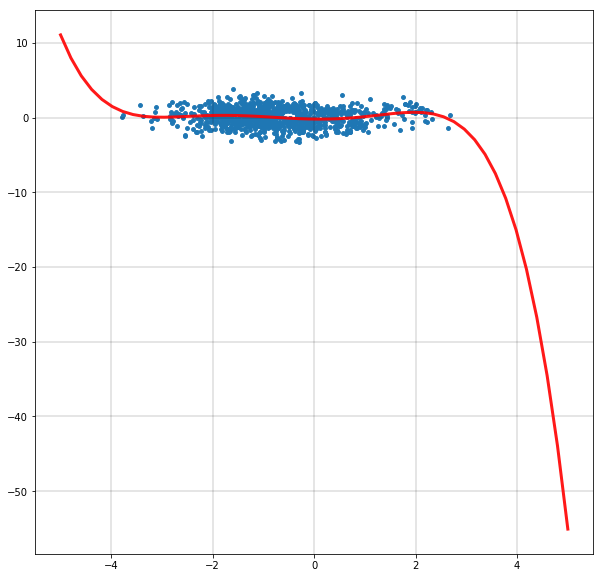

In [17]:
pml = 990
plt.figure(figsize=(10,10))
plt.scatter(generate_X_reduced(XX, pml)[:,1],generate_y_reduced(XX, pml), s = 15)

x = np.linspace(-5,5,50).reshape(50,1)
y =[]
for i in range(50):
    y.append(G_pml_predict(x[i],pml,Betas_reduced))
plt.plot(x,np.array(y), color = 'r',alpha = 0.9, linewidth = 3)
plt.grid(linestyle='-', linewidth='0.2', color='black')
plt.show()

### Illustration of fitted regression

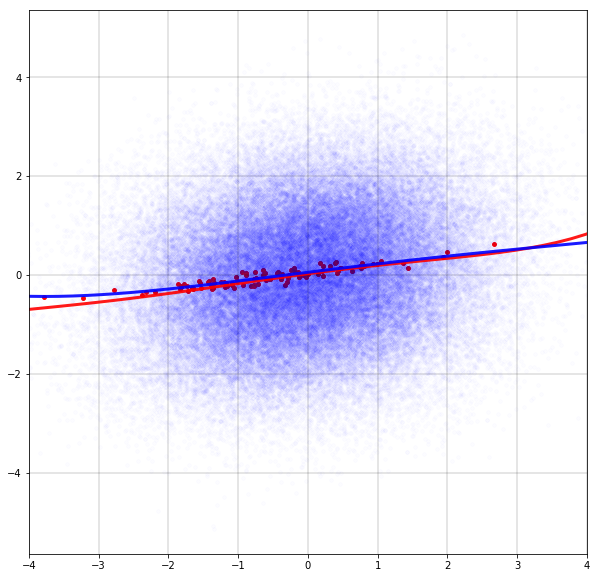

In [20]:
p = 35
l = 9

plt.figure(figsize=(10,10))
plt.scatter(generate_X(XX,l)[:,1],generate_y(XX,Betas,p,l), s = 15 , c = 'r')
plt.scatter(generate_X_reduced(XX, p-l)[:,1],generate_y_reduced(XX,p-l), s = 15, c = 'b', alpha= 0.01)

x = np.linspace(-5,5,50).reshape(50,1)
y =[]
for i in range(50):
    y.append(q_pl_predict(x[i],p,l,Betas))



y_reduced =[]
for i in range(50):
    y_reduced.append(G_pml_predict(x[i],p-l,Betas_reduced))
    
plt.plot(x,np.array(y_reduced), color = 'r',alpha = 0.9, linewidth = 3)
plt.plot(x,np.array(y), color = 'b',alpha = 0.9, linewidth = 3)
plt.xlim((-4,4))
plt.grid(linestyle='-', linewidth='0.2', color='black')
plt.show()

### Explicit formula for $\hat{a}_{p,l,k}(x)$:

#### $\hat{a}_{p,l,k} = \mathbb{E} \left[ H_k(\xi) \hat{Q}_{p,l}(x - h\nabla U(x) + \sqrt{2h}\xi)\right] =\int_{-\infty}^{\infty} H_k(\xi) \hat{Q}_{p,l}(x - h\nabla U(x) + \sqrt{2h}\xi) \varphi (\xi) d \xi$

#### $\hat{Q}_{p,l} (y) = \sum_{i=0}^{i=m} \beta_i y^i$

#### $\hat{a}_{p,l,k} = \int_{-\infty}^{\infty} H_k(\xi)  \left[ \sum_{i=0}^{i=m} \beta_i (x - h\nabla U(x) + \sqrt{2h}\xi)^i \right] \varphi (\xi) d \xi = \left [ \hat{x} = x - h\nabla U(x)\right] = \sum_{i=0}^{i=m} \beta_i\sum_{j=0}^{j=i} C_i^j \hat{x}^{i-j} (\sqrt{2h})^j \int_{-\infty}^{\infty} H_k (\xi) \xi^j \varphi (\xi)d \xi$ 

####  $\text{since }\quad \xi^j = j! \sum_{s = 0}^{s \leq j/2} \frac{1}{2^s} \frac{1}{s! \sqrt{(j-2s)!}}H_{j-2s}(\xi) \quad \text{we have}$:

#### $\hat{a}_{p,l,k} = \sum_{i=0}^{i=m}  \sum_{j=0}^{j=i} \sum_{s = 0}^{s \leq j/2} j! \frac{1}{2^s} \frac{1}{s!\sqrt{(j-2s)!}}\beta_i C_i^j \hat{x}^{i-j} (\sqrt{2h})^j \int_{-\infty}^{\infty} H_k(\xi) H_{j - 2s}(\xi)\varphi(\xi) d \xi $

#### $\text{and}\quad \int_{-\infty}^{\infty} H_k(\xi) H_{j - 2s}(\xi) \varphi(\xi) d \xi = \begin{cases}  1&\text{if $ k = j-2s$}\\ 0 &\text{else} \end{cases}$

In [21]:
def a_plk(X,p,l,k):
    h = 0.1
    S = 0
    x_hat = X[l-1] - h*f_grad(X[l-1])
    for i in range(6):
        for j in range (i+1):
            for s in range (int(j/2 +1)):
                if (k ==j - 2*s):
                    S = S +  Betas[p,l,i] * comb(N=i, k = j, exact = True) * x_hat**(i-j) * math.factorial(j) *\
                    1/math.factorial(s) *  1 / np.sqrt(math.factorial(j-2*s)) *np.sqrt(2*h)**j /2**s
                else:
                    pass
    return S

def a_plk_reduced(X,p,l,k):
    h = 0.1
    S = 0
    x_hat = X[l-1] - h*f_grad(X[l-1])
    for i in range(6):
        for j in range (i+1):
            for s in range (int(j/2 +1)):
                if (k ==j - 2*s):
                    S = S +  Betas_reduced[p-l,i] * comb(N=i, k = j, exact = True) * x_hat**(i-j) * math.factorial(j) *\
                    1/math.factorial(s) *  1 / np.sqrt(math.factorial(j-2*s)) *np.sqrt(2*h)**j /2**s
                else:
                    pass
    return S

## Check on train sample

In [22]:
def estimator(XX):
    Pi = np.empty(XX.shape[0])
    for i in tqdm(range(XX.shape[0])):
        Pi[i] = local_weighted_estimator(XX[i])
    return Pi

P = estimator(XX)
print ("variance of weighted estimator (1.4) on training sample:",P.var(ddof=1))

100%|██████████| 100/100 [00:00<00:00, 31655.12it/s]

variance of weighted estimator (1.4) on training sample: 0.04631084783018952


In [23]:
def M_bias(k,X,Z,reduced = True):
    N = X.shape[0]
    S = 0
    for p in range(N):
        for l in range (p+1):
            if reduced == True:
                s = a_plk_reduced(X,p,l,k)* H(k,Z[l])
            else:
                s = a_plk(X,p,l,k)* H(k,Z[l])
            S = S + s
    return S/N

In [24]:
def estimator_bias(k,XX,ZZ,Betas,first, last, reduced = True):
    M_results = Parallel(n_jobs=-1)(delayed(M_bias)(k,XX[i],ZZ[i],reduced = reduced)for i in range(first, last))
    return np.array(M_results).reshape(-1)

### check formula ( full)

In [138]:
time_1 = timeit.default_timer()
print ("P =",local_weighted_estimator(X_validate))
for i in range(1,3):
    print ("M ({})= {} [Time:{}]".format(i,M_bias(i,X_validate,Z_validate,reduced=False),timeit.default_timer()-time_1))

P = 0.0896981746584
M (1)= [[ 0.10194419]] [Time:156.97201072803]
M (2)= [[ 0.00260107]] [Time:297.77400452899747]


In [139]:
X = XX[40]
Z = ZZ[40]
time_1 = timeit.default_timer()
print ("P =",local_weighted_estimator(X))
for i in range(1,3):
    print ("M ({})= {} [Time:{}]".format(i,M_bias(i,X,Z,reduced = False),timeit.default_timer()-time_1))

P = 0.054590279912
M (1)= [[ 0.0907372]] [Time:156.19423513300717]
M (2)= [[ 0.00321447]] [Time:295.947419292992]


### check formula ( reduced)

In [140]:
time_1 = timeit.default_timer()
print ("P =",local_weighted_estimator(X_validate))
for i in range(1,3):
    print ("M ({})= {} [Time:{}]".format(i,M_bias(i,X_validate,Z_validate),timeit.default_timer()-time_1))

P = 0.0896981746584
M (1)= [[ 0.12847653]] [Time:158.57743013696745]
M (2)= [[-0.05245554]] [Time:299.8546754239942]


In [141]:
X = XX[40]
Z = ZZ[40]
time_1 = timeit.default_timer()
print ("P =",local_weighted_estimator(X))
for i in range(1,3):
    print ("M ({})= {} [Time:{}]".format(i,M_bias(i,X,Z),timeit.default_timer()-time_1))

P = 0.054590279912
M (1)= [[ 0.08504518]] [Time:159.9116860679933]
M (2)= [[-0.02707352]] [Time:303.3484227239969]


In [152]:
print ('Variance of Pi = ',P.var(ddof = 1))
print ('-----------------------------------------------------')
print ('Variance of new estimator (K=1)= ',(P-M_1).var(ddof = 1))
print ("=====================================================")

Variance of Pi =  0.0463108478302
-----------------------------------------------------
Variance of new estimator (K=1)=  0.00864086475028


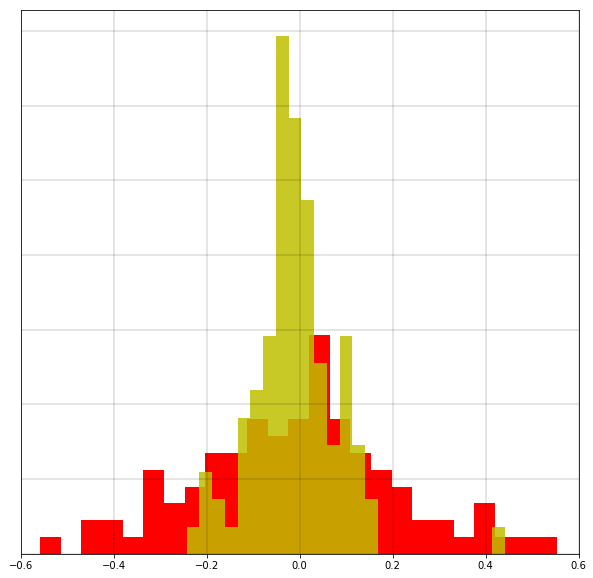

In [153]:
plt.figure(figsize=(10,10))
weights = np.ones_like(P)/(len(P)) 

n, bins, patches = plt.hist(P.reshape(-1,1), bins = 25, facecolor='r',weights=weights,normed = True,
                            alpha=1, label="Distribution of $\pi$")

n, bins, patches = plt.hist((P-M_1).reshape(-1,1), bins = 25, facecolor='y', weights=weights, normed = True,
                            alpha=0.85, label="Distribution of $\pi - M^1_N$")

#plt.legend(loc=2, prop={'size': 12})
plt.grid(linestyle='-', linewidth='0.2', color='black')
plt.xlim(-0.6,0.6)
plt.tick_params(
    axis='y',
    color = 'w',
    labelcolor = 'w',
    which='both')
plt.show()

## Check on test sample

In [25]:
np.random.seed(987)
X, Z = generate_lmc(a,d,10000)
XX_test, ZZ_test = generate_paths(X,200,a,d,1000)
P_test = estimator(XX_test)

100%|██████████| 200/200 [00:00<00:00, 54418.48it/s]


In [26]:
# np.save('GM_XX_test', XX_test)
# np.save('GM_ZZ_test', ZZ_test)

In [ ]:
M_results_test_1 = estimator_bias(1,XX_test,ZZ_test,Betas, 0, 100)
np.save('GM_M_results_test_1_reduced.npy',M_results_test_1)
del M_results_test_1

In [ ]:
M_results_test_2 = estimator_bias(1,XX_test,ZZ_test,Betas, 100, 200)
np.save('GM_M_results_test_2_reduced.npy',M_results_test_2)
del M_results_test_2

In [27]:
M_test_1 = np.load("GM_M_results_test_1.npy")

M_test_2 = np.load("GM_M_results_test_2.npy")

MMM_test = np.concatenate([M_test_1,M_test_2])

In [48]:
M_test_1_reduced = np.load("GM_M_results_test_1_reduced.npy")

M_test_2_reduced = np.load("GM_M_results_test_2_reduced.npy")

MMM_test_reduced = np.concatenate([M_test_1_reduced,M_test_2_reduced])

In [29]:
print ('Variance of Pi on test = ',P_test.var(ddof = 1))
print ('-----------------------------------------------------')
print ('Variance of new estimator (K=1) on test = ',(P_test-MMM_test).var(ddof = 1))
print ("=====================================================")
print ('Variance of new estimator (K=1) on test = ',(P_test-MMM_test_reduced).var(ddof = 1))
print ("=====================================================")

Variance of Pi on test =  0.04300085359543429
-----------------------------------------------------
Variance of new estimator (K=1) on test =  0.0859951108513878
Variance of new estimator (K=1) on test =  0.006026144719002076


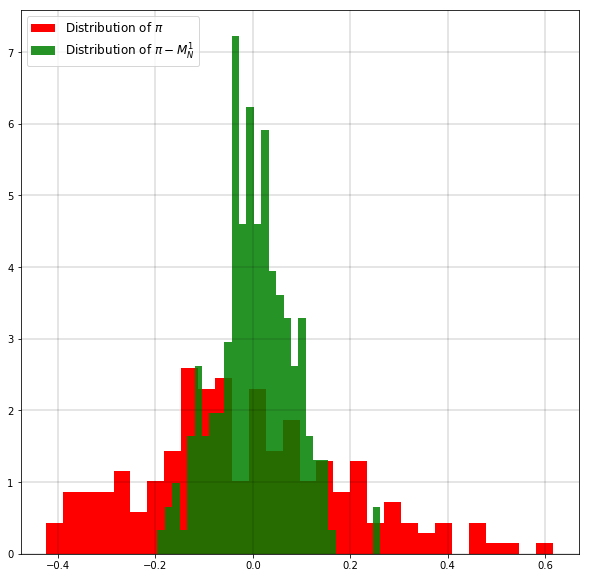

In [33]:
plt.figure(figsize=(10,10))
n, bins, patches = plt.hist(P_test.reshape(-1,1),30, facecolor='r', density=True,
                            alpha=1, label="Distribution of $\pi$")

n, bins, patches = plt.hist((P_test-MMM_test_reduced).reshape(-1,1), 30, density=True, facecolor='g', 
                            alpha=0.85, label="Distribution of $\pi - M^1_N$")

plt.legend(loc=2, prop={'size': 12})
plt.grid(linestyle='-', linewidth=0.2, color='black')
plt.show()

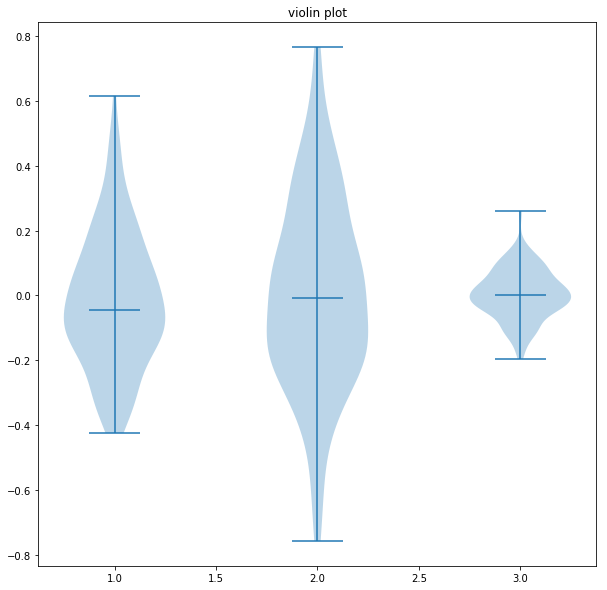

In [51]:
plt.figure(figsize=(10,10))

# generate some random test data
all_data = [P_test, P_test - MMM_test, P_test - MMM_test_reduced]

# plot violin plot
plt.violinplot(all_data,
                   showmeans=False,
                   showmedians=True)
plt.title('violin plot')

plt.show()